In [55]:
from hcdr import make_prep_pipeline, load_process_data
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve, f1_score
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import warnings
import pprint

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve

from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score

In [2]:
from IPython.display import display, HTML, Javascript

js_getResults = """<script>
alert("Hello! I am an alert box!");
</script>"""

def alert():
    display(HTML(js_getResults))

In [3]:
%%time
processed_data, num_attribs, cat_attribs = load_process_data()
y = processed_data['TARGET']
X = processed_data

data_prep_pipeline = make_prep_pipeline(num_attribs, cat_attribs)

loaded data


/Users/deepakduggirala/Documents/courses/AML526/home-credit-default-risk/main/hcdr.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[mask] = np.NaN
/Users/deepakduggirala/miniforge3/envs/ml/lib/python3.10/site-packages/pandas/core/frame.py:3718: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)
/Users/deepakduggirala/Documents/courses/AML526/home-credit-default-risk/main/hcdr.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pand

CPU times: user 25.3 s, sys: 10.3 s, total: 35.7 s
Wall time: 40.9 s


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
X_train.shape, X_valid.shape, X_test.shape

((184506, 354), (61502, 354), (61503, 354))

In [5]:
%%time
np.random.seed(42)
pipeline_with_selector = Pipeline([
    ("preparation", data_prep_pipeline),
    ("feature_selector", SelectFromModel(LogisticRegression(
        C=0.006,
        penalty='l1',
        solver='liblinear',
        class_weight='balanced',
        max_iter=1000,
        random_state=0))),
])

_ = pipeline_with_selector.fit(X_train, y_train)

CPU times: user 31.8 s, sys: 1.9 s, total: 33.7 s
Wall time: 35.2 s


In [ ]:
# full_pipeline_with_predictor = Pipeline([("preparation", ), ("classifier", LogisticRegression(max_iter=1000, class_weight="balanced"))])

In [9]:
cat_pipeline = data_prep_pipeline.transformer_list[1][1]
cat_features = [f'{base}_{c}'for base, ohe_c in zip(
    cat_attribs, cat_pipeline.named_steps['ohe'].categories_) for c in ohe_c]
features = num_attribs + cat_features
print(f'features: {len(features)}, num_attribs: {len(num_attribs)}, cat_features: {len(cat_features)}')

selector_model = pipeline_with_selector.named_steps['feature_selector']
selected_features = list(np.array(features)[selector_model.get_support()])
print(f'attribs: {len(num_attribs + cat_attribs)}, features: {len(features)}, selected_features={len(selected_features)}')

selected_attribs = set([f if f in num_attribs else '_'.join(f.split('_')[:-1]) for f in selected_features])
unused_attribs = set(num_attribs+cat_attribs) - selected_attribs

features: 491, num_attribs: 287, cat_features: 204
attribs: 334, features: 491, selected_features=173


In [10]:
X_train_xfm = pipeline_with_selector.transform(X_train)
X_valid_xfm = pipeline_with_selector.transform(X_valid)
X_test_xfm = pipeline_with_selector.transform(X_test)
X_train_xfm.shape, X_valid_xfm.shape, X_test_xfm.shape

((184506, 173), (61502, 173), (61503, 173))

- model trained on imbalanced data without class weights
    - before calibrating
        - roc_auc: array([0.7724, 0.771 , 0.7701])
        - brier_score_loss: 0.06664830707609969
        - balanced accuracy: 0.5149346058272263
    - after calibrating
        - roc_auc: array([0.772 , 0.7724, 0.7696])
        - brier_score_loss: 0.06664322893419379
        - balanced accuracy: 0.5091304497535165
        
- model trained on imbalanced data with class weights='balanced'
     - before calibrating
        - roc_auc: array([0.773 , 0.7716, 0.7703])
        - brier_score_loss: 0.19512646167105077
        - balanced accuracy: 0.703257727000132
    - after calibrating
        - roc_auc: array([0.7724, 0.7729, 0.7699])
        - brier_score_loss: 0.0667547326764966
        - balanced accuracy: 0.5105770698589965
- model trained on balanced data (under sampling)
     - before calibrating
        - roc_auc: array([0.7754, 0.7696, 0.7693])
        - brier_score_loss: 0.19632197619141536
        - balanced accuracy: 0.7014247479211023
    - after calibrating on balanced validation set, if trained on imbalaned validation set, we see the same graph as the model trained on imbalanced data (does not look calibrated - briar score: 0.1968608664965747)
        - roc_auc: array([0.7754, 0.7709, 0.7688])
        - brier_score_loss: 0.0669254811821098
        - balanced accuracy: 0.5137704482327218
        
If trained, calibrated and evaluated on balanced datasets, the briar score mostly remains at 0.197.

In [142]:
%%time
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_xfm, y_train)

CPU times: user 20.1 s, sys: 3.1 s, total: 23.2 s
Wall time: 3.61 s


LogisticRegression(class_weight='balanced', max_iter=1000)

In [143]:
y_train_pred_proba = model.predict_proba(X_train_xfm)[:, 1]
y_valid_pred_proba = model.predict_proba(X_valid_xfm)[:, 1]
y_test_pred_proba = model.predict_proba(X_test_xfm)[:, 1]
np.round((
    roc_auc_score(y_train, y_train_pred_proba), 
    roc_auc_score(y_valid, y_valid_pred_proba), 
    roc_auc_score(y_test, y_test_pred_proba)
), 4)

array([0.773 , 0.7716, 0.7703])

(array([ 2610.,  9283., 10981.,  9965.,  8618.,  7112.,  5499.,  4181.,
         2601.,   653.]),
 array([8.92440119e-06, 1.00008032e-01, 2.00007140e-01, 3.00006247e-01,
        4.00005355e-01, 5.00004462e-01, 6.00003570e-01, 7.00002677e-01,
        8.00001785e-01, 9.00000892e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

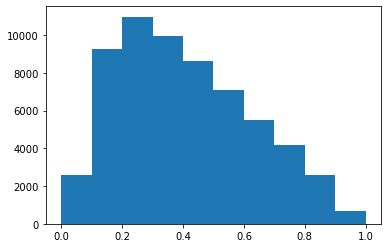

In [144]:
plt.hist(y_test_pred_proba)

In [154]:
mask = (y_test_pred_proba > 0.9)

np.mean(y_test.take(np.where(mask)[0]))

0.47013782542113325

In [97]:
np.sum(y_test_pred_proba > 0.5), np.sum(y_test)

(20046, 4928)

In [101]:
prob_true, prob_pred

(array([0.01454637, 0.03604507, 0.079911  , 0.16993802, 0.33743085]),
 array([0.13571334, 0.29711846, 0.4935256 , 0.69017636, 0.85993747]))

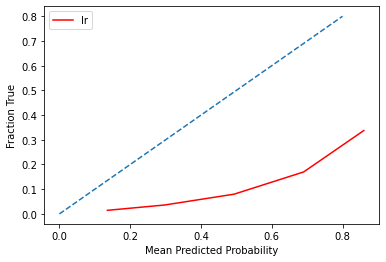

In [98]:
n_bins=5
plt.plot(np.arange(0,1,1/n_bins), np.arange(0,1,1/n_bins), '--')
y_test_pred_proba = model.predict_proba(X_test_xfm)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_test_pred_proba, n_bins=n_bins)
plt.plot(prob_pred, prob_true, 'r', label='lr' )
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction True')
plt.legend() 

In [102]:
brier_score_loss(y_test, y_test_pred_proba), np.sqrt(brier_score_loss(y_test, y_test_pred_proba))

(0.19512646167105077, 0.4417312097543604)

In [140]:
balanced_accuracy_score(y_test, model.predict_proba(X_test_xfm)[:,1]>0.495)

0.7037774890818417

In [86]:
0.5**2 # brier score of an dummy estimator that always predicts with 0.5 probability

0.25

In [87]:
def get_sample_weights(y):
    # only works if y is one dimensional array of 0s and 1s
    f1 = np.sum(y)/y.shape[0]
    f0 = 1-f1
    w0,w1 = 0.5/f0, 0.5/f1
    return np.where(y_valid==0, w0, w1)

np.sum(get_sample_weights(y_valid)), y_valid.shape[0]

(61502.00000000001, 61502)

In [103]:
%%time
calib_model = CalibratedClassifierCV(base_estimator=model, method='isotonic', cv='prefit')
calib_model.fit(X_valid_xfm, y_valid)

CPU times: user 107 ms, sys: 91.2 ms, total: 198 ms
Wall time: 77.1 ms


CalibratedClassifierCV(base_estimator=LogisticRegression(class_weight='balanced',
                                                         max_iter=1000),
                       cv='prefit', method='isotonic')

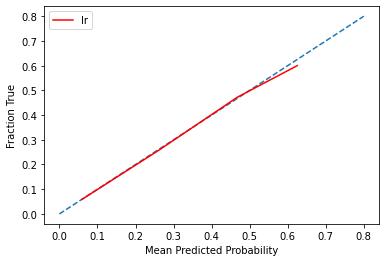

In [104]:
n_bins=5
plt.plot(np.arange(0,1,1/n_bins), np.arange(0,1,1/n_bins), '--')
y_test_pred_proba = calib_model.predict_proba(X_test_xfm)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_test_pred_proba, n_bins=n_bins)
plt.plot(prob_pred, prob_true, 'r', label='lr' )
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction True')
plt.legend() 

In [105]:
brier_score_loss(y_test, y_test_pred_proba), np.sqrt(brier_score_loss(y_test, y_test_pred_proba))

(0.0667547326764966, 0.2583693725589328)

In [106]:
y_train_pred_proba = calib_model.predict_proba(X_train_xfm)[:, 1]
y_valid_pred_proba = calib_model.predict_proba(X_valid_xfm)[:, 1]
y_test_pred_proba = calib_model.predict_proba(X_test_xfm)[:, 1]
np.round((
    roc_auc_score(y_train, y_train_pred_proba), 
    roc_auc_score(y_valid, y_valid_pred_proba), 
    roc_auc_score(y_test, y_test_pred_proba)
), 4)

array([0.7724, 0.7729, 0.7699])

In [ ]:
# array([0.773 , 0.7716, 0.7703])
# array([0.7724, 0.771 , 0.7701])

In [109]:
np.sum(y_test_pred_proba > 0.5), np.sum(y_test)

(201, 4928)

(array([33074., 15918.,  4704.,  4301.,  1348.,  1471.,   399.,    87.,
          106.,    95.]),
 array([0.    , 0.0625, 0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375,
        0.5   , 0.5625, 0.625 ]),
 <BarContainer object of 10 artists>)

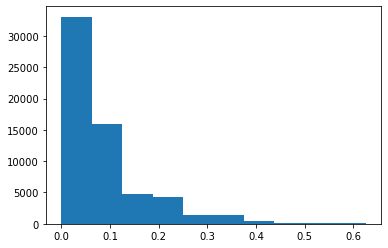

In [108]:
plt.hist(y_test_pred_proba)

In [129]:
balanced_accuracy_score(y_test, calib_model.predict_proba(X_test_xfm)[:,1]>0.082)

0.703875401002003

## Calibrating KNN

In [27]:
%%time
model = KNeighborsClassifier(n_neighbors=701, weights='distance', p=2, n_jobs=)
model.fit(X_train_xfm, y_train)

CPU times: user 24.7 ms, sys: 59.1 ms, total: 83.8 ms
Wall time: 92.1 ms


KNeighborsClassifier(n_neighbors=701, weights='distance')

In [28]:
%%time
y_train_pred_proba = model.predict_proba(X_train_xfm)[:, 1]
y_valid_pred_proba = model.predict_proba(X_valid_xfm)[:, 1]
y_test_pred_proba = model.predict_proba(X_test_xfm)[:, 1]
np.round((
    roc_auc_score(y_train, y_train_pred_proba), 
    roc_auc_score(y_valid, y_valid_pred_proba), 
    roc_auc_score(y_test, y_test_pred_proba)
), 4)

array([1.    , 0.7414, 0.737 ])

(array([1.0779e+04, 2.4001e+04, 1.3557e+04, 6.8840e+03, 3.3730e+03,
        1.6520e+03, 8.4100e+02, 3.3900e+02, 7.2000e+01, 5.0000e+00]),
 array([0.00577504, 0.03649519, 0.06721533, 0.09793548, 0.12865562,
        0.15937576, 0.19009591, 0.22081605, 0.2515362 , 0.28225634,
        0.31297648]),
 <BarContainer object of 10 artists>)

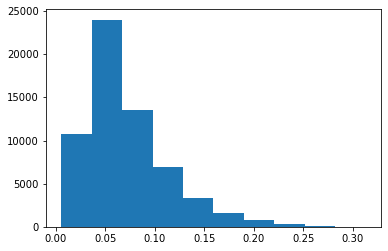

In [34]:
plt.hist(y_test_pred_proba)

In [33]:
prob_true, prob_pred

(array([0.0759901 , 0.35769657]), array([0.06973345, 0.22267102]))

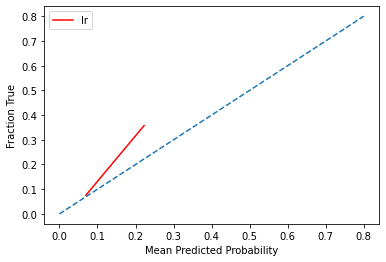

In [29]:
n_bins=5
plt.plot(np.arange(0,1,1/n_bins), np.arange(0,1,1/n_bins), '--')
y_test_pred_proba = model.predict_proba(X_test_xfm)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_test_pred_proba, n_bins=n_bins)
plt.plot(prob_pred, prob_true, 'r', label='lr' )
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction True')
plt.legend() 

In [36]:
brier_score_loss(y_test, y_test_pred_proba)

0.06976025677132337

In [38]:
%%time
base_model = KNeighborsClassifier(n_neighbors=701, weights='distance', p=2)
base_model.fit(X_train_xfm, y_train)
calib_model = CalibratedClassifierCV(base_estimator=base_model, method='isotonic', cv='prefit')
calib_model.fit(X_valid_xfm, y_valid)

CPU times: user 5min 28s, sys: 1min 39s, total: 7min 8s
Wall time: 3min 13s


CalibratedClassifierCV(base_estimator=KNeighborsClassifier(n_neighbors=701,
                                                           weights='distance'),
                       cv='prefit', method='isotonic')

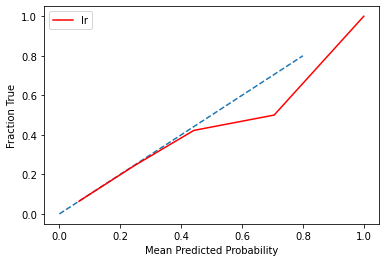

In [39]:
n_bins=5
plt.plot(np.arange(0,1,1/n_bins), np.arange(0,1,1/n_bins), '--')
y_test_pred_proba = calib_model.predict_proba(X_test_xfm)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_test_pred_proba, n_bins=n_bins)
plt.plot(prob_pred, prob_true, 'r', label='lr' )
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction True')
plt.legend() 

In [42]:
brier_score_loss(y_test, y_test_pred_proba)

0.06890980804212246

In [43]:
prob_true, prob_pred 

(array([0.06421872, 0.24412752, 0.4224924 , 0.5       , 1.        ]),
 array([0.06436994, 0.24609477, 0.44168476, 0.70543112, 1.        ]))

(array([4.3395e+04, 1.3006e+04, 4.4280e+03, 3.4000e+02, 2.9100e+02,
        3.8000e+01, 2.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

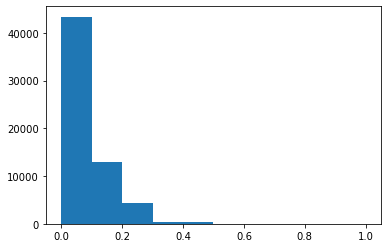

In [51]:
plt.hist(y_test_pred_proba)

In [58]:
np.sum(y_test_pred_proba>0.4), np.sum(y_test)

(334, 4928)

In [57]:
%%time
y_train_pred_proba = calib_model.predict_proba(X_train_xfm)[:, 1]
y_valid_pred_proba = calib_model.predict_proba(X_valid_xfm)[:, 1]
y_test_pred_proba = calib_model.predict_proba(X_test_xfm)[:, 1]
np.round((
    roc_auc_score(y_train, y_train_pred_proba), 
    roc_auc_score(y_valid, y_valid_pred_proba), 
    roc_auc_score(y_test, y_test_pred_proba)
), 4)

CPU times: user 27min 8s, sys: 8min 7s, total: 35min 16s
Wall time: 14min 38s


array([1.    , 0.7427, 0.7367])

In [ ]:
n_jobs=